# GD. ResNet Ablation Study
# 1. 라이브러리 import

In [1]:
import urllib3
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D,\
     Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.utils import plot_model

# 2. 데이터 로드

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
urllib3.disable_warnings()

tfds.disable_progress_bar()  

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[20%:]', 'train[:20%]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True
)


In [4]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [5]:
# 데이터의 개수 확인
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [6]:
# 클래스 개수 확인
ds_info.features["label"].num_classes

2

In [7]:
# 라벨의 이름 확인
ds_info.features["label"].names

['cat', 'dog']

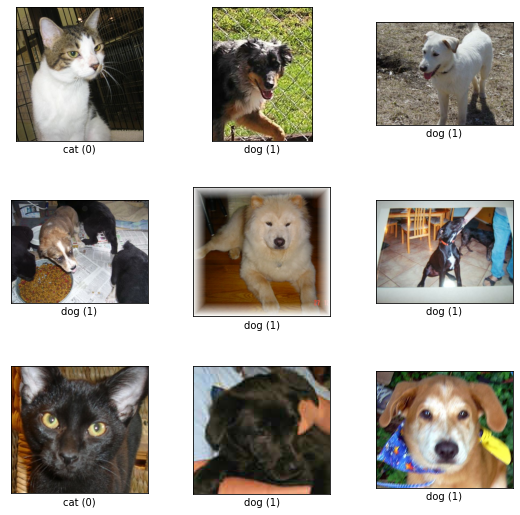

In [8]:
fig = tfds.show_examples(ds_train, ds_info)

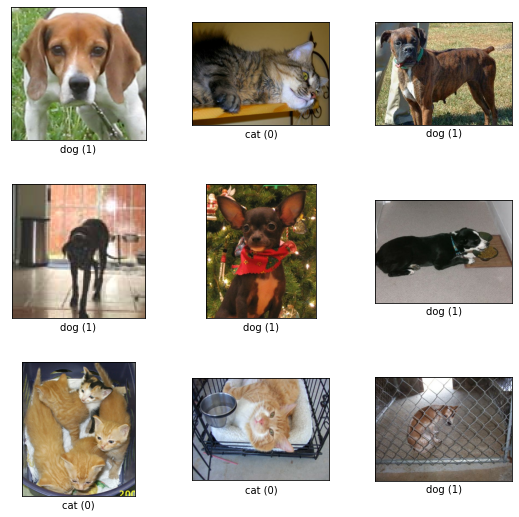

In [9]:
fig = tfds.show_examples(ds_test, ds_info)

# 3. 데이터 전처리

In [10]:
# 각 채널별 최댓값인 255로 정규화(normalize)
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [11]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

# 4. ResNet 모델링

In [12]:
  def build_resnet_block(input_layer, num_cnn=3, channel=64, block_num=1,is_50 = False, is_plain = False):
    # 입력 레이어
    x = input_layer
    if not is_50:
    # CNN 레이어
        for cnn_num in range(num_cnn):
            identity = x
            x = Conv2D(
                filters=channel,
                kernel_size=(3,3),
                strides=(1,1),
                kernel_initializer='he_normal',
                padding='same',
                use_bias=False
            )(x)
            x = BatchNormalization()(x)
            x = Activation(activations.relu)(x)
            x = Conv2D(
                filters=channel,
                kernel_size=(3,3),
                strides=(1,1),
                kernel_initializer='he_normal',
                padding='same',
                use_bias=False
            )(x)
            x = BatchNormalization()(x)
            if not is_plain:
                identity_channel = identity.shape.as_list()[-1]    

                if identity_channel != channel:
                    identity = Conv2D(channel, kernel_size=(1,1), strides=(1,1), use_bias=False, padding="same")(identity)
                # shortcut connection
                x = Add()([x,identity])
                x = Activation(activations.relu)(x)   
            else:
                pass
    else :
        for cnn_num in range(num_cnn):
            # channel이 64인 경우
            if channel==64:
                identity = x
                x = Conv2D(
                    filters=channel,
                    kernel_size=(1,1),
                    strides=(1,1),
                    kernel_initializer='he_normal',
                    padding='valid',
                    use_bias=False
                )(x)
                x = BatchNormalization()(x)
                x = Activation(activations.relu)(x)
                x = Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    strides=(1,1),
                    kernel_initializer='he_normal',
                    padding='same',
                    use_bias=False
                )(x)
                x = BatchNormalization()(x)
                x = Activation(activations.relu)(x)
                x = Conv2D(
                    filters=channel * 4,
                    kernel_size=(1,1),
                    strides=(1,1),
                    kernel_initializer='he_normal',
                    padding='valid',
                    use_bias=False
                )(x)
                x = BatchNormalization()(x)

                if not is_plain:
                    if cnn_num==0:

                        identity_channel = identity.shape.as_list()[-1]

                        if identity_channel != channel:
                            identity = Conv2D(filters=channel*4, kernel_size=(1, 1), strides=2, use_bias=False, padding="valid")(identity)
                        # shortcut connection
                        x = Add()([x,identity])
                        x = Activation(activations.relu, axis = 3)(x)

                    else:
                        identity_channel = identity.shape.as_list()[-1]

                        if identity_channel != channel:
                            identity = Conv2D(filters=channel*4, kernel_size=(1, 1), strides=1, use_bias=False, padding="valid")(identity)
                        # shortcut connection
                        x = Add()([x,identity])
                        x = Activation(activations.relu, axis = 3)(x)      
                else:
                    pass

            # channel이 64가 아닌 경우
            else:
                identity = x
                if cnn_num==0:
                    x = Conv2D(
                        filters=channel,
                        kernel_size=(1,1),
                        strides=(2,2),
                        kernel_initializer='he_normal',
                        padding='valid',
                        use_bias=False
                    )(x)
                else:
                    x = Conv2D(
                        filters=channel,
                        kernel_size=(1,1),
                        strides=(1,1),
                        kernel_initializer='he_normal',
                        padding='valid',
                        use_bias=False
                    )(x)                    
                x = BatchNormalization()(x)
                x = Activation(activations.relu)(x)
                x = Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    strides=(1,1),
                    kernel_initializer='he_normal',
                    padding='same',
                    use_bias=False
                )(x)
                x = BatchNormalization()(x)
                x = Activation(activations.relu)(x)
                x = Conv2D(
                    filters=channel * 4,
                    kernel_size=(1,1),
                    strides=(1,1),
                    kernel_initializer='he_normal',
                    padding='valid',
                    use_bias=False
                )(x)
                x = BatchNormalization()(x)

                if not is_plain:
                    if cnn_num==0:

                        identity_channel = identity.shape.as_list()[-1]

                        if identity_channel != channel:
                            identity = Conv2D(filters=channel*4, kernel_size=(1, 1), strides=2, use_bias=False, padding="valid")(identity)
                        # shortcut connection
                        x = Add()([x,identity])
                        x = Activation(activations.relu, axis = 3)(x)

                    else:
                        identity_channel = identity.shape.as_list()[-1]

                        if identity_channel != channel:
                            identity = Conv2D(filters=channel*4, kernel_size=(1, 1), strides=1, use_bias=False, padding="valid")(identity)
                        # shortcut connection
                        x = Add()([x,identity])
                        x = Activation(activations.relu, axis = 3)(x)      
                else:
                    pass

    return x

In [13]:
def build_resnet(input_shape=(32,32,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=10, is_50 = False, is_plain = False):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    if is_50:
        num_cnn_list = [3,4,6,3]
        channel_list = [64,128,256,512]
        num_classes = 10
        
    input_layer = Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    #conv1층
    output = ZeroPadding2D(padding=(3, 3))(output)
    output = Conv2D(filters=64,
                       kernel_size = (7,7),
                       strides = (2,2)
                       )(output)
    output = BatchNormalization()(output)
    
    #conv2_x pooling
    output = MaxPooling2D(pool_size = (3,3),
                          strides = (2,2))(output)    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i,
            is_50=is_50,
            is_plain=is_plain
        )    
    output = AveragePooling2D(padding = 'same')(output)
    output = Flatten(name='flatten')(output)
    output = Dense(512, activation='relu', name='fc1')(output)    
    output = Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

## 4-1. ResNet-34

In [14]:
resnet_34 = build_resnet(input_shape=(224,224,3), is_50 = False)
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
______________________________________________________________________________________________

## 4-2. ResNet-50
-> 에러가 발생했는데 원인을 찾지 못함...

## 4-3. Plain-34

In [15]:
plain_resnet_34 = build_resnet(input_shape=(224,224,3), is_50 = False, is_plain = True)
plain_resnet_34.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 230, 230, 3)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_33 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 55, 55, 64)        36864     
_________________________________________________________________
batch_normalization_34 (Batc (None, 55, 55, 64)        256 

## 4-4. Plain-50

In [16]:
plain_resnet_50 = build_resnet(input_shape=(224,224,3), is_50 = True, is_plain = True)
plain_resnet_50.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 230, 230, 3)       0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_66 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 55, 55, 64)        4096      
_________________________________________________________________
batch_normalization_67 (Batc (None, 55, 55, 64)        256 

# 5. 모델 훈련

In [17]:
BATCH_SIZE = 16
EPOCH = 10

In [18]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

## 5-1. ResNet-34

In [19]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[20%:]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[:20%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
 190/1163 [===>..........................] - ETA: 12:03 - loss: 2.3454 - accuracy: 0.5013

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 255/1163 [=====>........................] - ETA: 11:11 - loss: 1.9351 - accuracy: 0.4988

 277/1163 [======>.......................] - ETA: 10:54 - loss: 1.8376 - accuracy: 0.5005

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 346/1163 [=======>......................] - ETA: 10:01 - loss: 1.6131 - accuracy: 0.4998

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 419/1163 [=========>....................] - ETA: 9:06 - loss: 1.4564 - accuracy: 0.5001

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 446/1163 [==========>...................] - ETA: 8:46 - loss: 1.4105 - accuracy: 0.5015

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 683/1163 [================>.............] - ETA: 5:51 - loss: 1.1659 - accuracy: 0.5012

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 840/1163 [====================>.........] - ETA: 3:56 - loss: 1.0796 - accuracy: 0.5004

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 863/1163 [=====================>........] - ETA: 3:39 - loss: 1.0696 - accuracy: 0.5007

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 885/1163 [=====================>........] - ETA: 3:23 - loss: 1.0604 - accuracy: 0.4998

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 939/1163 [=======================>......] - ETA: 2:43 - loss: 1.0394 - accuracy: 0.5021

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 951/1163 [=======================>......] - ETA: 2:34 - loss: 1.0355 - accuracy: 0.5018

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.9748 - accuracy: 0.5024

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 940s 796ms/step - loss: 0.9748 - accuracy: 0.5024 - val_loss: 0.7194 - val_accuracy: 0.4978
Epoch 2/10
 191/1163 [===>..........................] - ETA: 11:52 - loss: 0.7080 - accuracy: 0.4885

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 257/1163 [=====>........................] - ETA: 11:03 - loss: 0.7069 - accuracy: 0.4939

 280/1163 [======>.......................] - ETA: 10:45 - loss: 0.7065 - accuracy: 0.4931

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 349/1163 [========>.....................] - ETA: 9:54 - loss: 0.7051 - accuracy: 0.4975

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 421/1163 [=========>....................] - ETA: 9:01 - loss: 0.7040 - accuracy: 0.4970

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 443/1163 [==========>...................] - ETA: 8:45 - loss: 0.7037 - accuracy: 0.4989

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 686/1163 [================>.............] - ETA: 5:47 - loss: 0.7034 - accuracy: 0.5039

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 838/1163 [====================>.........] - ETA: 3:56 - loss: 0.7028 - accuracy: 0.5036

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 866/1163 [=====================>........] - ETA: 3:36 - loss: 0.7030 - accuracy: 0.5032

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 888/1163 [=====================>........] - ETA: 3:20 - loss: 0.7031 - accuracy: 0.5032

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 942/1163 [=======================>......] - ETA: 2:40 - loss: 0.7030 - accuracy: 0.5018

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 954/1163 [=======================>......] - ETA: 2:32 - loss: 0.7029 - accuracy: 0.5022

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7029 - accuracy: 0.5015

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 922s 793ms/step - loss: 0.7029 - accuracy: 0.5015 - val_loss: 0.7006 - val_accuracy: 0.5039
Epoch 3/10
 195/1163 [====>.........................] - ETA: 11:44 - loss: 0.7010 - accuracy: 0.5026

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 256/1163 [=====>........................] - ETA: 11:00 - loss: 0.7020 - accuracy: 0.5027

 281/1163 [======>.......................] - ETA: 10:42 - loss: 0.7030 - accuracy: 0.5000

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 348/1163 [=======>......................] - ETA: 9:53 - loss: 0.7027 - accuracy: 0.4978

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 420/1163 [=========>....................] - ETA: 9:00 - loss: 0.7058 - accuracy: 0.4952

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 443/1163 [==========>...................] - ETA: 8:44 - loss: 0.7058 - accuracy: 0.4944

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 685/1163 [================>.............] - ETA: 5:47 - loss: 0.7042 - accuracy: 0.4960

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 842/1163 [====================>.........] - ETA: 3:53 - loss: 0.7036 - accuracy: 0.4943

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 867/1163 [=====================>........] - ETA: 3:35 - loss: 0.7035 - accuracy: 0.4943

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 886/1163 [=====================>........] - ETA: 3:21 - loss: 0.7035 - accuracy: 0.4941

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 940/1163 [=======================>......] - ETA: 2:42 - loss: 0.7034 - accuracy: 0.4946

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 952/1163 [=======================>......] - ETA: 2:33 - loss: 0.7032 - accuracy: 0.4948

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7026 - accuracy: 0.4974

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 921s 792ms/step - loss: 0.7026 - accuracy: 0.4974 - val_loss: 0.6971 - val_accuracy: 0.4961
Epoch 4/10
 198/1163 [====>.........................] - ETA: 11:43 - loss: 0.6999 - accuracy: 0.4978

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 258/1163 [=====>........................] - ETA: 10:59 - loss: 0.6996 - accuracy: 0.4961

 281/1163 [======>.......................] - ETA: 10:41 - loss: 0.6997 - accuracy: 0.4933

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 349/1163 [========>.....................] - ETA: 9:51 - loss: 0.7010 - accuracy: 0.4910

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 421/1163 [=========>....................] - ETA: 8:59 - loss: 0.7008 - accuracy: 0.4927

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 443/1163 [==========>...................] - ETA: 8:43 - loss: 0.7009 - accuracy: 0.4907

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 686/1163 [================>.............] - ETA: 5:46 - loss: 0.7010 - accuracy: 0.4912

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 840/1163 [====================>.........] - ETA: 3:54 - loss: 0.7011 - accuracy: 0.4908

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 866/1163 [=====================>........] - ETA: 3:35 - loss: 0.7010 - accuracy: 0.4916

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 892/1163 [======================>.......] - ETA: 3:17 - loss: 0.7009 - accuracy: 0.4921

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 946/1163 [=======================>......] - ETA: 2:37 - loss: 0.7006 - accuracy: 0.4919

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 958/1163 [=======================>......] - ETA: 2:29 - loss: 0.7005 - accuracy: 0.4926

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7020 - accuracy: 0.4931

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 920s 791ms/step - loss: 0.7020 - accuracy: 0.4931 - val_loss: 0.6974 - val_accuracy: 0.5028
Epoch 5/10
 199/1163 [====>.........................] - ETA: 11:41 - loss: 0.7030 - accuracy: 0.4956

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 258/1163 [=====>........................] - ETA: 10:58 - loss: 0.7013 - accuracy: 0.5000

 280/1163 [======>.......................] - ETA: 10:42 - loss: 0.7011 - accuracy: 0.5007

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 349/1163 [========>.....................] - ETA: 9:52 - loss: 0.7000 - accuracy: 0.5091

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 421/1163 [=========>....................] - ETA: 8:59 - loss: 0.7001 - accuracy: 0.5080

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 447/1163 [==========>...................] - ETA: 8:40 - loss: 0.7002 - accuracy: 0.5084

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 686/1163 [================>.............] - ETA: 5:46 - loss: 0.7031 - accuracy: 0.5029

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 844/1163 [====================>.........] - ETA: 3:51 - loss: 0.7026 - accuracy: 0.5000

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 866/1163 [=====================>........] - ETA: 3:35 - loss: 0.7025 - accuracy: 0.4998

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 888/1163 [=====================>........] - ETA: 3:19 - loss: 0.7024 - accuracy: 0.4997

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 942/1163 [=======================>......] - ETA: 2:40 - loss: 0.7023 - accuracy: 0.4999

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 954/1163 [=======================>......] - ETA: 2:31 - loss: 0.7021 - accuracy: 0.5002

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7026 - accuracy: 0.5027

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 920s 791ms/step - loss: 0.7026 - accuracy: 0.5027 - val_loss: 0.6995 - val_accuracy: 0.5017
Epoch 6/10
 199/1163 [====>.........................] - ETA: 11:40 - loss: 0.7082 - accuracy: 0.4994

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 260/1163 [=====>........................] - ETA: 10:55 - loss: 0.7060 - accuracy: 0.4986

 280/1163 [======>.......................] - ETA: 10:39 - loss: 0.7058 - accuracy: 0.4980

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 351/1163 [========>.....................] - ETA: 9:48 - loss: 0.7051 - accuracy: 0.4986

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 424/1163 [=========>....................] - ETA: 8:55 - loss: 0.7039 - accuracy: 0.4981

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 451/1163 [==========>...................] - ETA: 8:36 - loss: 0.7036 - accuracy: 0.4985

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 688/1163 [================>.............] - ETA: 5:44 - loss: 0.7017 - accuracy: 0.5042

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 844/1163 [====================>.........] - ETA: 3:51 - loss: 0.7009 - accuracy: 0.5026

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 866/1163 [=====================>........] - ETA: 3:35 - loss: 0.7009 - accuracy: 0.5020

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 889/1163 [=====================>........] - ETA: 3:18 - loss: 0.7007 - accuracy: 0.5027

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 943/1163 [=======================>......] - ETA: 2:39 - loss: 0.7010 - accuracy: 0.5013

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 955/1163 [=======================>......] - ETA: 2:30 - loss: 0.7011 - accuracy: 0.5012

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7018 - accuracy: 0.4994

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 919s 790ms/step - loss: 0.7018 - accuracy: 0.4994 - val_loss: 0.7017 - val_accuracy: 0.5043
Epoch 7/10
 201/1163 [====>.........................] - ETA: 11:35 - loss: 0.7028 - accuracy: 0.4934

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 262/1163 [=====>........................] - ETA: 10:52 - loss: 0.7029 - accuracy: 0.4943

 286/1163 [======>.......................] - ETA: 10:35 - loss: 0.7023 - accuracy: 0.4943

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 353/1163 [========>.....................] - ETA: 9:47 - loss: 0.7021 - accuracy: 0.5004

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 425/1163 [=========>....................] - ETA: 8:55 - loss: 0.7014 - accuracy: 0.5040

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 447/1163 [==========>...................] - ETA: 8:39 - loss: 0.7012 - accuracy: 0.5035

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 690/1163 [================>.............] - ETA: 5:43 - loss: 0.7007 - accuracy: 0.5035

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 844/1163 [====================>.........] - ETA: 3:51 - loss: 0.7000 - accuracy: 0.5047

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 871/1163 [=====================>........] - ETA: 3:32 - loss: 0.6999 - accuracy: 0.5046

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 890/1163 [=====================>........] - ETA: 3:18 - loss: 0.6999 - accuracy: 0.5035

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 944/1163 [=======================>......] - ETA: 2:39 - loss: 0.6998 - accuracy: 0.5034

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 956/1163 [=======================>......] - ETA: 2:30 - loss: 0.6997 - accuracy: 0.5037

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.6999 - accuracy: 0.5007

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 919s 790ms/step - loss: 0.6999 - accuracy: 0.5007 - val_loss: 0.7114 - val_accuracy: 0.4976
Epoch 8/10
 200/1163 [====>.........................] - ETA: 11:39 - loss: 0.7005 - accuracy: 0.4988

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 261/1163 [=====>........................] - ETA: 10:55 - loss: 0.7002 - accuracy: 0.4971

 281/1163 [======>.......................] - ETA: 10:40 - loss: 0.7005 - accuracy: 0.4960

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 353/1163 [========>.....................] - ETA: 9:48 - loss: 0.7015 - accuracy: 0.4979

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 425/1163 [=========>....................] - ETA: 8:56 - loss: 0.7007 - accuracy: 0.4994

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 452/1163 [==========>...................] - ETA: 8:36 - loss: 0.7002 - accuracy: 0.5021

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 690/1163 [================>.............] - ETA: 5:43 - loss: 0.6996 - accuracy: 0.4992

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 847/1163 [====================>.........] - ETA: 3:49 - loss: 0.6996 - accuracy: 0.4987

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 867/1163 [=====================>........] - ETA: 3:35 - loss: 0.6995 - accuracy: 0.4985

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 892/1163 [======================>.......] - ETA: 3:17 - loss: 0.6995 - accuracy: 0.4979

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 946/1163 [=======================>......] - ETA: 2:37 - loss: 0.6996 - accuracy: 0.4978

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 958/1163 [=======================>......] - ETA: 2:29 - loss: 0.6998 - accuracy: 0.4987

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.6996 - accuracy: 0.5009

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 920s 791ms/step - loss: 0.6996 - accuracy: 0.5009 - val_loss: 0.7152 - val_accuracy: 0.4965
Epoch 9/10
 198/1163 [====>.........................] - ETA: 11:41 - loss: 0.6997 - accuracy: 0.4946

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 264/1163 [=====>........................] - ETA: 10:53 - loss: 0.7006 - accuracy: 0.4938

 283/1163 [======>.......................] - ETA: 10:39 - loss: 0.7007 - accuracy: 0.4938

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 356/1163 [========>.....................] - ETA: 9:46 - loss: 0.6998 - accuracy: 0.4982

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 428/1163 [==========>...................] - ETA: 8:54 - loss: 0.6993 - accuracy: 0.4955

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 451/1163 [==========>...................] - ETA: 8:37 - loss: 0.6990 - accuracy: 0.4970

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 693/1163 [================>.............] - ETA: 5:41 - loss: 0.6993 - accuracy: 0.4976

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 846/1163 [====================>.........] - ETA: 3:50 - loss: 0.7004 - accuracy: 0.4964

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 869/1163 [=====================>........] - ETA: 3:33 - loss: 0.7002 - accuracy: 0.4972

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 897/1163 [======================>.......] - ETA: 3:13 - loss: 0.7006 - accuracy: 0.4969

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 951/1163 [=======================>......] - ETA: 2:33 - loss: 0.7007 - accuracy: 0.4965

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 963/1163 [=======================>......] - ETA: 2:25 - loss: 0.7006 - accuracy: 0.4964

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7011 - accuracy: 0.4981

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 918s 790ms/step - loss: 0.7011 - accuracy: 0.4981 - val_loss: 0.6942 - val_accuracy: 0.4972
Epoch 10/10
 203/1163 [====>.........................] - ETA: 11:37 - loss: 0.6980 - accuracy: 0.5006

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 261/1163 [=====>........................] - ETA: 10:55 - loss: 0.6981 - accuracy: 0.5007

 285/1163 [======>.......................] - ETA: 10:37 - loss: 0.6981 - accuracy: 0.4993

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 353/1163 [========>.....................] - ETA: 9:48 - loss: 0.6982 - accuracy: 0.5060

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 425/1163 [=========>....................] - ETA: 8:56 - loss: 0.6980 - accuracy: 0.5050

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 450/1163 [==========>...................] - ETA: 8:37 - loss: 0.6978 - accuracy: 0.5058

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 690/1163 [================>.............] - ETA: 5:43 - loss: 0.6975 - accuracy: 0.5084

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 850/1163 [====================>.........] - ETA: 3:47 - loss: 0.6980 - accuracy: 0.5077

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 871/1163 [=====================>........] - ETA: 3:32 - loss: 0.6978 - accuracy: 0.5089

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 896/1163 [======================>.......] - ETA: 3:13 - loss: 0.6978 - accuracy: 0.5087

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 950/1163 [=======================>......] - ETA: 2:34 - loss: 0.6976 - accuracy: 0.5099

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 962/1163 [=======================>......] - ETA: 2:25 - loss: 0.6976 - accuracy: 0.5099

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.6984 - accuracy: 0.5088

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 919s 790ms/step - loss: 0.6984 - accuracy: 0.5088 - val_loss: 0.7005 - val_accuracy: 0.4901


## 5.2 Plain-34

In [20]:
plain_resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = plain_resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[20%:]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[:20%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
 196/1163 [====>.........................] - ETA: 12:10 - loss: 1.5984 - accuracy: 0.5061

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 253/1163 [=====>........................] - ETA: 11:14 - loss: 1.3991 - accuracy: 0.5035

 277/1163 [======>.......................] - ETA: 10:53 - loss: 1.3395 - accuracy: 0.5047

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 344/1163 [=======>......................] - ETA: 9:57 - loss: 1.2147 - accuracy: 0.5114

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 417/1163 [=========>....................] - ETA: 9:00 - loss: 1.1364 - accuracy: 0.5072

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 445/1163 [==========>...................] - ETA: 8:38 - loss: 1.1102 - accuracy: 0.5069

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 681/1163 [================>.............] - ETA: 5:44 - loss: 1.0044 - accuracy: 0.5021

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 838/1163 [====================>.........] - ETA: 3:51 - loss: 0.9484 - accuracy: 0.5009

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 862/1163 [=====================>........] - ETA: 3:33 - loss: 0.9420 - accuracy: 0.5008

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 887/1163 [=====================>........] - ETA: 3:15 - loss: 0.9353 - accuracy: 0.5007

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 942/1163 [=======================>......] - ETA: 2:36 - loss: 0.9219 - accuracy: 0.4987

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 954/1163 [=======================>......] - ETA: 2:28 - loss: 0.9190 - accuracy: 0.4994

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.8804 - accuracy: 0.4988

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 901s 769ms/step - loss: 0.8804 - accuracy: 0.4988 - val_loss: 0.6946 - val_accuracy: 0.5024
Epoch 2/10
 194/1163 [====>.........................] - ETA: 11:10 - loss: 0.7045 - accuracy: 0.5039

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 253/1163 [=====>........................] - ETA: 10:30 - loss: 0.7043 - accuracy: 0.5030

 279/1163 [======>.......................] - ETA: 10:12 - loss: 0.7055 - accuracy: 0.5000

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 345/1163 [=======>......................] - ETA: 9:26 - loss: 0.7050 - accuracy: 0.5004

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 417/1163 [=========>....................] - ETA: 8:36 - loss: 0.7043 - accuracy: 0.5015

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 442/1163 [==========>...................] - ETA: 8:19 - loss: 0.7038 - accuracy: 0.5030

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 682/1163 [================>.............] - ETA: 5:33 - loss: 0.7044 - accuracy: 0.5027

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 839/1163 [====================>.........] - ETA: 3:44 - loss: 0.7042 - accuracy: 0.5010

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 865/1163 [=====================>........] - ETA: 3:26 - loss: 0.7041 - accuracy: 0.5010

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 890/1163 [=====================>........] - ETA: 3:09 - loss: 0.7040 - accuracy: 0.5018

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 944/1163 [=======================>......] - ETA: 2:31 - loss: 0.7040 - accuracy: 0.5010

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 956/1163 [=======================>......] - ETA: 2:23 - loss: 0.7040 - accuracy: 0.5000

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7041 - accuracy: 0.4971

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 879s 756ms/step - loss: 0.7041 - accuracy: 0.4971 - val_loss: 0.7126 - val_accuracy: 0.4931
Epoch 3/10
 197/1163 [====>.........................] - ETA: 11:08 - loss: 0.7056 - accuracy: 0.5095

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 260/1163 [=====>........................] - ETA: 10:25 - loss: 0.7032 - accuracy: 0.5087

 277/1163 [======>.......................] - ETA: 10:13 - loss: 0.7031 - accuracy: 0.5083

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 351/1163 [========>.....................] - ETA: 9:22 - loss: 0.7025 - accuracy: 0.5073

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 423/1163 [=========>....................] - ETA: 8:32 - loss: 0.7025 - accuracy: 0.5068

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 442/1163 [==========>...................] - ETA: 8:19 - loss: 0.7023 - accuracy: 0.5041

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 688/1163 [================>.............] - ETA: 5:28 - loss: 0.7018 - accuracy: 0.5015

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 841/1163 [====================>.........] - ETA: 3:43 - loss: 0.7016 - accuracy: 0.5009

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 863/1163 [=====================>........] - ETA: 3:27 - loss: 0.7015 - accuracy: 0.5004

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 888/1163 [=====================>........] - ETA: 3:10 - loss: 0.7014 - accuracy: 0.5002

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 942/1163 [=======================>......] - ETA: 2:33 - loss: 0.7017 - accuracy: 0.4996

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 954/1163 [=======================>......] - ETA: 2:24 - loss: 0.7017 - accuracy: 0.5001

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7029 - accuracy: 0.4971

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 878s 755ms/step - loss: 0.7029 - accuracy: 0.4971 - val_loss: 0.7023 - val_accuracy: 0.5026
Epoch 4/10
 193/1163 [===>..........................] - ETA: 11:11 - loss: 0.7021 - accuracy: 0.5159

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 262/1163 [=====>........................] - ETA: 10:23 - loss: 0.7026 - accuracy: 0.5115

 279/1163 [======>.......................] - ETA: 10:11 - loss: 0.7026 - accuracy: 0.5105

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 352/1163 [========>.....................] - ETA: 9:20 - loss: 0.7015 - accuracy: 0.5075

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 425/1163 [=========>....................] - ETA: 8:30 - loss: 0.7008 - accuracy: 0.5084

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 448/1163 [==========>...................] - ETA: 8:14 - loss: 0.7007 - accuracy: 0.5078

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 689/1163 [================>.............] - ETA: 5:28 - loss: 0.7012 - accuracy: 0.5041

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 842/1163 [====================>.........] - ETA: 3:42 - loss: 0.7007 - accuracy: 0.5021

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 865/1163 [=====================>........] - ETA: 3:26 - loss: 0.7008 - accuracy: 0.5014

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 888/1163 [=====================>........] - ETA: 3:10 - loss: 0.7008 - accuracy: 0.5008

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 942/1163 [=======================>......] - ETA: 2:32 - loss: 0.7015 - accuracy: 0.5005

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 954/1163 [=======================>......] - ETA: 2:24 - loss: 0.7014 - accuracy: 0.5005

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7013 - accuracy: 0.4998

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 878s 755ms/step - loss: 0.7013 - accuracy: 0.4998 - val_loss: 0.6935 - val_accuracy: 0.5028
Epoch 5/10
 195/1163 [====>.........................] - ETA: 11:07 - loss: 0.7014 - accuracy: 0.4920

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 259/1163 [=====>........................] - ETA: 10:23 - loss: 0.7015 - accuracy: 0.4954

 282/1163 [======>.......................] - ETA: 10:07 - loss: 0.7014 - accuracy: 0.4942

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 350/1163 [========>.....................] - ETA: 9:21 - loss: 0.7016 - accuracy: 0.4968

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 423/1163 [=========>....................] - ETA: 8:31 - loss: 0.7014 - accuracy: 0.4993

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 445/1163 [==========>...................] - ETA: 8:16 - loss: 0.7012 - accuracy: 0.4986

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 687/1163 [================>.............] - ETA: 5:29 - loss: 0.6998 - accuracy: 0.5007

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 845/1163 [====================>.........] - ETA: 3:39 - loss: 0.7010 - accuracy: 0.5004

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 868/1163 [=====================>........] - ETA: 3:24 - loss: 0.7010 - accuracy: 0.5009

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 891/1163 [=====================>........] - ETA: 3:08 - loss: 0.7010 - accuracy: 0.4996

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 945/1163 [=======================>......] - ETA: 2:30 - loss: 0.7002 - accuracy: 0.5023

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 957/1163 [=======================>......] - ETA: 2:22 - loss: 0.7002 - accuracy: 0.5024

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7005 - accuracy: 0.5016

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 878s 755ms/step - loss: 0.7005 - accuracy: 0.5016 - val_loss: 0.6981 - val_accuracy: 0.5009
Epoch 6/10
 199/1163 [====>.........................] - ETA: 11:07 - loss: 0.7024 - accuracy: 0.5082

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 258/1163 [=====>........................] - ETA: 10:25 - loss: 0.7032 - accuracy: 0.5039

 285/1163 [======>.......................] - ETA: 10:07 - loss: 0.7027 - accuracy: 0.5048

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 349/1163 [========>.....................] - ETA: 9:22 - loss: 0.7028 - accuracy: 0.4986

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 422/1163 [=========>....................] - ETA: 8:32 - loss: 0.7018 - accuracy: 0.4976

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 447/1163 [==========>...................] - ETA: 8:15 - loss: 0.7011 - accuracy: 0.5010

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 686/1163 [================>.............] - ETA: 5:30 - loss: 0.7013 - accuracy: 0.5020

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 844/1163 [====================>.........] - ETA: 3:40 - loss: 0.7017 - accuracy: 0.5012

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 870/1163 [=====================>........] - ETA: 3:22 - loss: 0.7019 - accuracy: 0.4998

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 893/1163 [======================>.......] - ETA: 3:06 - loss: 0.7025 - accuracy: 0.4994

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 948/1163 [=======================>......] - ETA: 2:28 - loss: 0.7022 - accuracy: 0.4997

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 960/1163 [=======================>......] - ETA: 2:20 - loss: 0.7020 - accuracy: 0.5007

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7016 - accuracy: 0.4989

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 878s 755ms/step - loss: 0.7016 - accuracy: 0.4989 - val_loss: 0.6939 - val_accuracy: 0.5009
Epoch 7/10
 199/1163 [====>.........................] - ETA: 11:07 - loss: 0.7012 - accuracy: 0.4921

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 263/1163 [=====>........................] - ETA: 10:23 - loss: 0.6992 - accuracy: 0.5007

 280/1163 [======>.......................] - ETA: 10:11 - loss: 0.6991 - accuracy: 0.5009

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 354/1163 [========>.....................] - ETA: 9:20 - loss: 0.6991 - accuracy: 0.5021

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 426/1163 [=========>....................] - ETA: 8:30 - loss: 0.6991 - accuracy: 0.5031

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 448/1163 [==========>...................] - ETA: 8:15 - loss: 0.6990 - accuracy: 0.5027

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 691/1163 [================>.............] - ETA: 5:26 - loss: 0.6990 - accuracy: 0.4996

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 847/1163 [====================>.........] - ETA: 3:38 - loss: 0.6996 - accuracy: 0.4982

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 866/1163 [=====================>........] - ETA: 3:25 - loss: 0.6997 - accuracy: 0.4973

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 891/1163 [=====================>........] - ETA: 3:08 - loss: 0.6997 - accuracy: 0.4969

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 945/1163 [=======================>......] - ETA: 2:30 - loss: 0.6996 - accuracy: 0.4966

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 957/1163 [=======================>......] - ETA: 2:22 - loss: 0.6996 - accuracy: 0.4967

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7005 - accuracy: 0.4977

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 878s 755ms/step - loss: 0.7005 - accuracy: 0.4977 - val_loss: 0.6961 - val_accuracy: 0.5063
Epoch 8/10
 203/1163 [====>.........................] - ETA: 11:01 - loss: 0.7028 - accuracy: 0.5009

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 260/1163 [=====>........................] - ETA: 10:23 - loss: 0.7022 - accuracy: 0.5075

 286/1163 [======>.......................] - ETA: 10:05 - loss: 0.7021 - accuracy: 0.5088

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 351/1163 [========>.....................] - ETA: 9:20 - loss: 0.7008 - accuracy: 0.5095

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 424/1163 [=========>....................] - ETA: 8:30 - loss: 0.7000 - accuracy: 0.5103

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 450/1163 [==========>...................] - ETA: 8:12 - loss: 0.7001 - accuracy: 0.5082

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 688/1163 [================>.............] - ETA: 5:28 - loss: 0.7003 - accuracy: 0.5066

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 847/1163 [====================>.........] - ETA: 3:38 - loss: 0.7001 - accuracy: 0.5061

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 871/1163 [=====================>........] - ETA: 3:21 - loss: 0.7000 - accuracy: 0.5057

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 892/1163 [======================>.......] - ETA: 3:07 - loss: 0.6998 - accuracy: 0.5061

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 947/1163 [=======================>......] - ETA: 2:29 - loss: 0.7001 - accuracy: 0.5060

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 959/1163 [=======================>......] - ETA: 2:21 - loss: 0.7000 - accuracy: 0.5067

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7008 - accuracy: 0.5063

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 877s 755ms/step - loss: 0.7008 - accuracy: 0.5063 - val_loss: 0.6993 - val_accuracy: 0.5022
Epoch 9/10
 202/1163 [====>.........................] - ETA: 11:03 - loss: 0.7052 - accuracy: 0.5019

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 262/1163 [=====>........................] - ETA: 10:22 - loss: 0.7049 - accuracy: 0.5036

 287/1163 [======>.......................] - ETA: 10:04 - loss: 0.7040 - accuracy: 0.5055

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 354/1163 [========>.....................] - ETA: 9:18 - loss: 0.7045 - accuracy: 0.5046

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 426/1163 [=========>....................] - ETA: 8:29 - loss: 0.7045 - accuracy: 0.5072

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 448/1163 [==========>...................] - ETA: 8:13 - loss: 0.7049 - accuracy: 0.5045

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 691/1163 [================>.............] - ETA: 5:26 - loss: 0.7032 - accuracy: 0.5024

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 845/1163 [====================>.........] - ETA: 3:39 - loss: 0.7027 - accuracy: 0.4996

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 873/1163 [=====================>........] - ETA: 3:20 - loss: 0.7026 - accuracy: 0.4978

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 895/1163 [======================>.......] - ETA: 3:05 - loss: 0.7025 - accuracy: 0.4980

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 949/1163 [=======================>......] - ETA: 2:27 - loss: 0.7023 - accuracy: 0.4978

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 961/1163 [=======================>......] - ETA: 2:19 - loss: 0.7022 - accuracy: 0.4982

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7018 - accuracy: 0.4984

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 877s 754ms/step - loss: 0.7018 - accuracy: 0.4984 - val_loss: 0.6933 - val_accuracy: 0.4991
Epoch 10/10
 204/1163 [====>.........................] - ETA: 11:00 - loss: 0.7002 - accuracy: 0.4954

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 266/1163 [=====>........................] - ETA: 10:18 - loss: 0.7004 - accuracy: 0.5038

 289/1163 [======>.......................] - ETA: 10:02 - loss: 0.7007 - accuracy: 0.5030

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 356/1163 [========>.....................] - ETA: 9:16 - loss: 0.7011 - accuracy: 0.5049

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 429/1163 [==========>...................] - ETA: 8:26 - loss: 0.7014 - accuracy: 0.5004

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 450/1163 [==========>...................] - ETA: 8:12 - loss: 0.7014 - accuracy: 0.5013

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 693/1163 [================>.............] - ETA: 5:24 - loss: 0.7004 - accuracy: 0.5042

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 847/1163 [====================>.........] - ETA: 3:38 - loss: 0.7000 - accuracy: 0.5042

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 874/1163 [=====================>........] - ETA: 3:19 - loss: 0.7001 - accuracy: 0.5049

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 895/1163 [======================>.......] - ETA: 3:05 - loss: 0.7001 - accuracy: 0.5045

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 950/1163 [=======================>......] - ETA: 2:27 - loss: 0.6998 - accuracy: 0.5058

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 962/1163 [=======================>......] - ETA: 2:18 - loss: 0.6998 - accuracy: 0.5060

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7002 - accuracy: 0.5032

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 877s 754ms/step - loss: 0.7002 - accuracy: 0.5032 - val_loss: 0.6934 - val_accuracy: 0.5082


## 5.3 Plain-50

In [21]:
plain_resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = plain_resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[20%:]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[:20%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
 197/1163 [====>.........................] - ETA: 2:13 - loss: 1.6706 - accuracy: 0.4968

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 255/1163 [=====>........................] - ETA: 2:04 - loss: 1.4578 - accuracy: 0.4931

 275/1163 [======>.......................] - ETA: 2:01 - loss: 1.4034 - accuracy: 0.4950

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 346/1163 [=======>......................] - ETA: 1:51 - loss: 1.2620 - accuracy: 0.4966

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 419/1163 [=========>....................] - ETA: 1:40 - loss: 1.1666 - accuracy: 0.4988

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 446/1163 [==========>...................] - ETA: 1:36 - loss: 1.1385 - accuracy: 0.4996

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 683/1163 [================>.............] - ETA: 1:03 - loss: 0.9883 - accuracy: 0.4965

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 840/1163 [====================>.........] - ETA: 42s - loss: 0.9376 - accuracy: 0.4933

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 861/1163 [=====================>........] - ETA: 40s - loss: 0.9317 - accuracy: 0.4936

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 888/1163 [=====================>........] - ETA: 36s - loss: 0.9247 - accuracy: 0.4936

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 943/1163 [=======================>......] - ETA: 29s - loss: 0.9114 - accuracy: 0.4950

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 955/1163 [=======================>......] - ETA: 27s - loss: 0.9088 - accuracy: 0.4951

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.8746 - accuracy: 0.4945

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 179s 146ms/step - loss: 0.8746 - accuracy: 0.4945 - val_loss: 0.7170 - val_accuracy: 0.4985
Epoch 2/10
 192/1163 [===>..........................] - ETA: 2:06 - loss: 0.6980 - accuracy: 0.4990

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 258/1163 [=====>........................] - ETA: 1:57 - loss: 0.6985 - accuracy: 0.5027

 278/1163 [======>.......................] - ETA: 1:55 - loss: 0.6987 - accuracy: 0.5025

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 349/1163 [========>.....................] - ETA: 1:46 - loss: 0.7003 - accuracy: 0.4987

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 422/1163 [=========>....................] - ETA: 1:36 - loss: 0.7015 - accuracy: 0.4993

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 447/1163 [==========>...................] - ETA: 1:33 - loss: 0.7023 - accuracy: 0.4986

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 686/1163 [================>.............] - ETA: 1:02 - loss: 0.7019 - accuracy: 0.4992

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 839/1163 [====================>.........] - ETA: 42s - loss: 0.7025 - accuracy: 0.5001

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 864/1163 [=====================>........] - ETA: 38s - loss: 0.7024 - accuracy: 0.5000

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 891/1163 [=====================>........] - ETA: 35s - loss: 0.7023 - accuracy: 0.5006

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 945/1163 [=======================>......] - ETA: 28s - loss: 0.7021 - accuracy: 0.5001

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 957/1163 [=======================>......] - ETA: 26s - loss: 0.7020 - accuracy: 0.5003

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7023 - accuracy: 0.5004

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 165s 142ms/step - loss: 0.7023 - accuracy: 0.5004 - val_loss: 0.7456 - val_accuracy: 0.4987
Epoch 3/10
 196/1163 [====>.........................] - ETA: 2:06 - loss: 0.7422 - accuracy: 0.5022

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 256/1163 [=====>........................] - ETA: 1:58 - loss: 0.7310 - accuracy: 0.5066

 282/1163 [======>.......................] - ETA: 1:55 - loss: 0.7292 - accuracy: 0.5060

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 347/1163 [=======>......................] - ETA: 1:46 - loss: 0.7251 - accuracy: 0.5000

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 420/1163 [=========>....................] - ETA: 1:37 - loss: 0.7250 - accuracy: 0.4987

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 448/1163 [==========>...................] - ETA: 1:33 - loss: 0.7233 - accuracy: 0.4990

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 684/1163 [================>.............] - ETA: 1:02 - loss: 0.7162 - accuracy: 0.4952

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 841/1163 [====================>.........] - ETA: 42s - loss: 0.7150 - accuracy: 0.4973

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 868/1163 [=====================>........] - ETA: 38s - loss: 0.7145 - accuracy: 0.4978

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 889/1163 [=====================>........] - ETA: 35s - loss: 0.7141 - accuracy: 0.4987

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 944/1163 [=======================>......] - ETA: 28s - loss: 0.7132 - accuracy: 0.4987

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 956/1163 [=======================>......] - ETA: 27s - loss: 0.7132 - accuracy: 0.4984

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7111 - accuracy: 0.4976

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 165s 142ms/step - loss: 0.7111 - accuracy: 0.4976 - val_loss: 0.6959 - val_accuracy: 0.5121
Epoch 4/10
 194/1163 [====>.........................] - ETA: 2:06 - loss: 0.7015 - accuracy: 0.4932

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 257/1163 [=====>........................] - ETA: 1:58 - loss: 0.7002 - accuracy: 0.4985

 283/1163 [======>.......................] - ETA: 1:55 - loss: 0.7003 - accuracy: 0.4976

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 350/1163 [========>.....................] - ETA: 1:46 - loss: 0.7019 - accuracy: 0.4993

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 421/1163 [=========>....................] - ETA: 1:36 - loss: 0.7019 - accuracy: 0.4988

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 447/1163 [==========>...................] - ETA: 1:33 - loss: 0.7020 - accuracy: 0.4985

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 686/1163 [================>.............] - ETA: 1:02 - loss: 0.7078 - accuracy: 0.4974

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 842/1163 [====================>.........] - ETA: 41s - loss: 0.7072 - accuracy: 0.4938

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 868/1163 [=====================>........] - ETA: 38s - loss: 0.7070 - accuracy: 0.4943

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 893/1163 [======================>.......] - ETA: 35s - loss: 0.7066 - accuracy: 0.4958

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 947/1163 [=======================>......] - ETA: 28s - loss: 0.7060 - accuracy: 0.4968

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 959/1163 [=======================>......] - ETA: 26s - loss: 0.7060 - accuracy: 0.4972

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7045 - accuracy: 0.4987

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 165s 142ms/step - loss: 0.7045 - accuracy: 0.4987 - val_loss: 0.7001 - val_accuracy: 0.4955
Epoch 5/10
 196/1163 [====>.........................] - ETA: 2:05 - loss: 0.7017 - accuracy: 0.5150

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 262/1163 [=====>........................] - ETA: 1:57 - loss: 0.7038 - accuracy: 0.5038

 282/1163 [======>.......................] - ETA: 1:54 - loss: 0.7032 - accuracy: 0.5029

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 354/1163 [========>.....................] - ETA: 1:45 - loss: 0.7018 - accuracy: 0.5034

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 426/1163 [=========>....................] - ETA: 1:35 - loss: 0.7019 - accuracy: 0.5047

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 448/1163 [==========>...................] - ETA: 1:32 - loss: 0.7024 - accuracy: 0.5047

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 690/1163 [================>.............] - ETA: 1:01 - loss: 0.7014 - accuracy: 0.5001

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 842/1163 [====================>.........] - ETA: 41s - loss: 0.7016 - accuracy: 0.5000

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 868/1163 [=====================>........] - ETA: 38s - loss: 0.7020 - accuracy: 0.5003

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 894/1163 [======================>.......] - ETA: 34s - loss: 0.7023 - accuracy: 0.5012

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 949/1163 [=======================>......] - ETA: 27s - loss: 0.7023 - accuracy: 0.5011

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 961/1163 [=======================>......] - ETA: 26s - loss: 0.7023 - accuracy: 0.5005

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7019 - accuracy: 0.4995

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 164s 141ms/step - loss: 0.7019 - accuracy: 0.4995 - val_loss: 0.7291 - val_accuracy: 0.5065
Epoch 6/10
 200/1163 [====>.........................] - ETA: 2:05 - loss: 0.7039 - accuracy: 0.4872

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 264/1163 [=====>........................] - ETA: 1:57 - loss: 0.7028 - accuracy: 0.4889

 281/1163 [======>.......................] - ETA: 1:54 - loss: 0.7024 - accuracy: 0.4893

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 354/1163 [========>.....................] - ETA: 1:45 - loss: 0.7016 - accuracy: 0.4949

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 427/1163 [==========>...................] - ETA: 1:35 - loss: 0.7014 - accuracy: 0.5001

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 452/1163 [==========>...................] - ETA: 1:32 - loss: 0.7016 - accuracy: 0.4986

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 691/1163 [================>.............] - ETA: 1:01 - loss: 0.7012 - accuracy: 0.4973

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 843/1163 [====================>.........] - ETA: 41s - loss: 0.7010 - accuracy: 0.4982

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 867/1163 [=====================>........] - ETA: 38s - loss: 0.7008 - accuracy: 0.4988

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 892/1163 [======================>.......] - ETA: 35s - loss: 0.7008 - accuracy: 0.4982

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 947/1163 [=======================>......] - ETA: 28s - loss: 0.7011 - accuracy: 0.4977

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 959/1163 [=======================>......] - ETA: 26s - loss: 0.7010 - accuracy: 0.4978

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7005 - accuracy: 0.5015

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 165s 142ms/step - loss: 0.7005 - accuracy: 0.5015 - val_loss: 0.6995 - val_accuracy: 0.4966
Epoch 7/10
 201/1163 [====>.........................] - ETA: 2:04 - loss: 0.7008 - accuracy: 0.4925

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 266/1163 [=====>........................] - ETA: 1:56 - loss: 0.7002 - accuracy: 0.4946

 281/1163 [======>.......................] - ETA: 1:54 - loss: 0.7006 - accuracy: 0.4967

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 356/1163 [========>.....................] - ETA: 1:44 - loss: 0.6997 - accuracy: 0.5009

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 429/1163 [==========>...................] - ETA: 1:35 - loss: 0.7002 - accuracy: 0.4985

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 449/1163 [==========>...................] - ETA: 1:32 - loss: 0.7005 - accuracy: 0.5003

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 693/1163 [================>.............] - ETA: 1:01 - loss: 0.7000 - accuracy: 0.5027

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 847/1163 [====================>.........] - ETA: 41s - loss: 0.7003 - accuracy: 0.4989

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 867/1163 [=====================>........] - ETA: 38s - loss: 0.7004 - accuracy: 0.4973

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 893/1163 [======================>.......] - ETA: 35s - loss: 0.7008 - accuracy: 0.4964

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 947/1163 [=======================>......] - ETA: 28s - loss: 0.7007 - accuracy: 0.4972

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 959/1163 [=======================>......] - ETA: 26s - loss: 0.7007 - accuracy: 0.4971

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7003 - accuracy: 0.5011

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 165s 142ms/step - loss: 0.7003 - accuracy: 0.5011 - val_loss: 0.7004 - val_accuracy: 0.5032
Epoch 8/10
 198/1163 [====>.........................] - ETA: 2:05 - loss: 0.6987 - accuracy: 0.4975

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 262/1163 [=====>........................] - ETA: 1:57 - loss: 0.6987 - accuracy: 0.5041

 285/1163 [======>.......................] - ETA: 1:54 - loss: 0.6986 - accuracy: 0.5048

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 354/1163 [========>.....................] - ETA: 1:45 - loss: 0.6993 - accuracy: 0.5049

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 426/1163 [=========>....................] - ETA: 1:36 - loss: 0.6989 - accuracy: 0.5016

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 449/1163 [==========>...................] - ETA: 1:33 - loss: 0.6990 - accuracy: 0.5021

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 691/1163 [================>.............] - ETA: 1:01 - loss: 0.7000 - accuracy: 0.5017

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 849/1163 [====================>.........] - ETA: 40s - loss: 0.7002 - accuracy: 0.5038

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 871/1163 [=====================>........] - ETA: 38s - loss: 0.7001 - accuracy: 0.5041

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 896/1163 [======================>.......] - ETA: 34s - loss: 0.7004 - accuracy: 0.5024

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 950/1163 [=======================>......] - ETA: 27s - loss: 0.7004 - accuracy: 0.5024

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 962/1163 [=======================>......] - ETA: 26s - loss: 0.7003 - accuracy: 0.5032

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7011 - accuracy: 0.5019

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 165s 142ms/step - loss: 0.7011 - accuracy: 0.5019 - val_loss: 0.7137 - val_accuracy: 0.4961
Epoch 9/10
 205/1163 [====>.........................] - ETA: 2:04 - loss: 0.7031 - accuracy: 0.4902

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 262/1163 [=====>........................] - ETA: 1:57 - loss: 0.7026 - accuracy: 0.4926

 288/1163 [======>.......................] - ETA: 1:54 - loss: 0.7036 - accuracy: 0.4894

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 353/1163 [========>.....................] - ETA: 1:45 - loss: 0.7030 - accuracy: 0.4880

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 425/1163 [=========>....................] - ETA: 1:36 - loss: 0.7027 - accuracy: 0.4863

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 450/1163 [==========>...................] - ETA: 1:32 - loss: 0.7030 - accuracy: 0.4865

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 690/1163 [================>.............] - ETA: 1:01 - loss: 0.7013 - accuracy: 0.4893

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 847/1163 [====================>.........] - ETA: 41s - loss: 0.7010 - accuracy: 0.4924

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 873/1163 [=====================>........] - ETA: 37s - loss: 0.7011 - accuracy: 0.4931

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 896/1163 [======================>.......] - ETA: 34s - loss: 0.7015 - accuracy: 0.4936

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 950/1163 [=======================>......] - ETA: 27s - loss: 0.7016 - accuracy: 0.4937

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 962/1163 [=======================>......] - ETA: 26s - loss: 0.7015 - accuracy: 0.4938

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7008 - accuracy: 0.4945

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 165s 142ms/step - loss: 0.7008 - accuracy: 0.4945 - val_loss: 0.7137 - val_accuracy: 0.4985
Epoch 10/10
 205/1163 [====>.........................] - ETA: 2:04 - loss: 0.7004 - accuracy: 0.5140

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 266/1163 [=====>........................] - ETA: 1:56 - loss: 0.7003 - accuracy: 0.5120

 288/1163 [======>.......................] - ETA: 1:54 - loss: 0.7003 - accuracy: 0.5124

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 357/1163 [========>.....................] - ETA: 1:45 - loss: 0.7008 - accuracy: 0.5110

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 430/1163 [==========>...................] - ETA: 1:35 - loss: 0.7002 - accuracy: 0.5090

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 453/1163 [==========>...................] - ETA: 1:32 - loss: 0.7002 - accuracy: 0.5068

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 694/1163 [================>.............] - ETA: 1:01 - loss: 0.7002 - accuracy: 0.5043

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 847/1163 [====================>.........] - ETA: 41s - loss: 0.7020 - accuracy: 0.5057

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 874/1163 [=====================>........] - ETA: 37s - loss: 0.7019 - accuracy: 0.5063

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 894/1163 [======================>.......] - ETA: 35s - loss: 0.7018 - accuracy: 0.5051

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 948/1163 [=======================>......] - ETA: 27s - loss: 0.7015 - accuracy: 0.5057

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 960/1163 [=======================>......] - ETA: 26s - loss: 0.7015 - accuracy: 0.5049

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7013 - accuracy: 0.5047

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 165s 142ms/step - loss: 0.7013 - accuracy: 0.5047 - val_loss: 0.6937 - val_accuracy: 0.4991


# 6. Loss

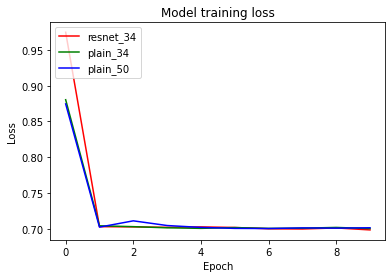

In [24]:
import matplotlib.pyplot as plt

plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_plain_34.history['loss'], 'g')
plt.plot(history_plain_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34', 'plain_50'], loc='upper left')
plt.show()

# 7. Accuracy

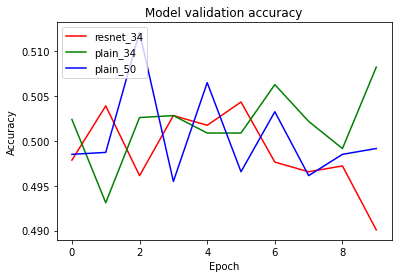

In [25]:
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'g')
plt.plot(history_plain_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34', 'plain_50'], loc='upper left')
plt.show()

# 회고
- loss를 학습할때를 보면 초반에는 낮아지다가 일정한 것을 볼 수 있다.
- 다른 분들의 결과를 찾아봤는데 정확도만 두고 판단했을때는 네개의 모델에서 큰 차이를 확인할 수 없다고 한다.
- ResNet-50는 뭐가 문제인지 다시 찾아보고 추가 해두어야겠다.

## 느낌 점
- 이번 노드를 하면서 '모델을 구현하는게 이렇게 어려운거구나...'라는 걸 알았다.
- 그리고 학습시간이 너무 오래 걸려서 다양한 시도를 하지 못해서 아쉽다.
- 모델 구현 진짜 열심히 공부해야겠다^^;;